
# TP : Prédire le prix de location de logements à Antananarivo avec une régression linéaire multiple

## 🎯 Objectifs pédagogiques

- Appliquer un pipeline de prétraitement complet sur un jeu de données semi-structuré.
- Gérer les variables qualitatives, les valeurs manquantes, la multicolinéarité et la scalabilité.
- Construire, tester et évaluer un modèle de régression linéaire multiple.
- Déployer le modèle dans une application Python Streamlit avec interface utilisateur.

## 🗂️ Jeu de données

Le jeu de données doit être collecté ou scrappé dans les pages comme Facebook. Il doit comporter les colonnes suivantes :

- `quartier` (catégorielle)
- `superficie` (numérique)
- `nombre_chambres` (numérique)
- `douche_wc`(interieur ou exterieur)
- `type_d_acces` (sans, moto, voiture, voiture_avec_par_parking)
- `meublé` (booléen:  oui ou non)
- `état_général` (catégorielle : bon, moyen, mauvais)
- `loyer_mensuel` (target)

## 🧪 Étapes du TP

### 📌 Partie 1 : Préparation des données
- Lecture du dataset brut
- Gestion des valeurs manquantes
- Encodage des variables catégorielles
- Création de variables dérivées
- Détection et suppression des variables fortement corrélées
- Standardisation et normalisation

### 📌 Partie 2 : Modélisation

- Séparation train/test
- Implémentation de la régression linéaire multiple
- Évaluation : R², RMSE
- Vérification des hypothèses d'élligibilité de la régression linéaire multiple (surtout sur les erreurs)

### 📌 Partie 3 : Optimisation du modèle

- Sélection de variables : backward elimination, RFE (à documenter)

### 📌 Partie 4 : Déploiement d’une application Streamlit

- Interface de saisi utilisateur
- Affichage du loyer prédit
- Visualisation des poids des variables
- Affichage sur la carte interactive

## 🧭 Carte interactive (option avancée)

Utiliser `streamlit-folium` pour permettre à l’utilisateur de cliquer sur une carte et de récupérer les coordonnées GPS. À partir de ces coordonnées, déterminer automatiquement le quartier en utilisant un fichier GeoJSON ou un système de polygones avec `geopandas`.

## 🔧 Technologies à utiliser

- `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `joblib`
- `streamlit`, `folium`, `streamlit-folium`
- Optionnel : `geopandas`, `shapely`

## 💡 Bonus

- Carte interactive avec folium
- Simuler des données additionnelles (pollution, sécurité)
- Tri automatique des caractéristiques influentes




## 📌 Partie 1 : Préparation des données

In [74]:
import math

# Lecture du dataset brut
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

maison = pd.read_csv("Location de maison Antananarivo  - Données finales - 1.csv")

maison_2 = pd.read_csv("Location de maison Antananarivo  - Données finales - 1.csv")


In [75]:
maison

,quartier,superficie,nombre_chambres,douche_wc,type_d_acces,meublé,état_général,loyer_mensuel
0,Location de maison Antananarivo - Données fin...,NaN,2,interieur,moto,non,moyen,300000
1,Andoharanofotsy,NaN,2,interieur,moto,non,mauvais,180000
2,Andoharanofotsy,NaN,1,exterieur,moto,non,mauvais,170000
3,Andoharanofotsy,NaN,2,exterieur,moto,non,moyen,250000
4,Andoharanofotsy,NaN,2,interieur,voiture_avec_parking,non,bon,450000
...,...,...,...,...,...,...,...,...
122,Faravohitra,51,2,interieur,sans,non,moyen,1000000
123,Manakambahiny,68,2,interieur,voiture_avec_parking,non,moyen,1000000
124,Amboditsiry,68,2,interieur,voiture,non,bon,1000000
125,Anosivavaka,94,3,interieur,sans,oui,bon,1000000


In [76]:
maison.dtypes

quartier           object
superficie         object
nombre_chambres     int64
douche_wc          object
type_d_acces       object
meublé             object
état_général       object
loyer_mensuel       int64
dtype: object

In [77]:
# Transform superficie into float
maison['superficie'] = maison['superficie'].apply(lambda x: x.replace(",", ".") if type(x) == str else x).astype(float)

In [78]:
maison.dtypes

quartier            object
superficie         float64
nombre_chambres      int64
douche_wc           object
type_d_acces        object
meublé              object
état_général        object
loyer_mensuel        int64
dtype: object

In [79]:
maison['meublé'] = maison['meublé'].apply(lambda x: "oui" if x == "True" else ("non" if x == "False" else x))

In [80]:
maison

,quartier,superficie,nombre_chambres,douche_wc,type_d_acces,meublé,état_général,loyer_mensuel
0,Location de maison Antananarivo - Données fin...,NaN,2,interieur,moto,non,moyen,300000
1,Andoharanofotsy,NaN,2,interieur,moto,non,mauvais,180000
2,Andoharanofotsy,NaN,1,exterieur,moto,non,mauvais,170000
3,Andoharanofotsy,NaN,2,exterieur,moto,non,moyen,250000
4,Andoharanofotsy,NaN,2,interieur,voiture_avec_parking,non,bon,450000
...,...,...,...,...,...,...,...,...
122,Faravohitra,51.0,2,interieur,sans,non,moyen,1000000
123,Manakambahiny,68.0,2,interieur,voiture_avec_parking,non,moyen,1000000
124,Amboditsiry,68.0,2,interieur,voiture,non,bon,1000000
125,Anosivavaka,94.0,3,interieur,sans,oui,bon,1000000


In [81]:
range_etat_general = [
    ("mauvais", 0, 300000),
    ("moyen", 300000, 800000),
    ("bon", 800000, math.inf)
]
maison['état_général'] = maison['loyer_mensuel'].apply(lambda x: range_etat_general[0][0] if range_etat_general[0][1] <= x < range_etat_general[0][2] else (range_etat_general[1][0] if range_etat_general[1][1] <= x < range_etat_general[1][2] else range_etat_general[2][0]))

In [82]:
maison

,quartier,superficie,nombre_chambres,douche_wc,type_d_acces,meublé,état_général,loyer_mensuel
0,Location de maison Antananarivo - Données fin...,NaN,2,interieur,moto,non,moyen,300000
1,Andoharanofotsy,NaN,2,interieur,moto,non,mauvais,180000
2,Andoharanofotsy,NaN,1,exterieur,moto,non,mauvais,170000
3,Andoharanofotsy,NaN,2,exterieur,moto,non,mauvais,250000
4,Andoharanofotsy,NaN,2,interieur,voiture_avec_parking,non,moyen,450000
...,...,...,...,...,...,...,...,...
122,Faravohitra,51.0,2,interieur,sans,non,bon,1000000
123,Manakambahiny,68.0,2,interieur,voiture_avec_parking,non,bon,1000000
124,Amboditsiry,68.0,2,interieur,voiture,non,bon,1000000
125,Anosivavaka,94.0,3,interieur,sans,oui,bon,1000000


In [83]:
# Encoding One-hot douche_wc
one_hot = pd.get_dummies(maison['douche_wc'])
maison = one_hot.join(maison)
maison = maison.drop('douche_wc',axis = 1)

In [84]:
maison

,exterieur,interieur,quartier,superficie,nombre_chambres,type_d_acces,meublé,état_général,loyer_mensuel
0,False,True,Location de maison Antananarivo - Données fin...,NaN,2,moto,non,moyen,300000
1,False,True,Andoharanofotsy,NaN,2,moto,non,mauvais,180000
2,True,False,Andoharanofotsy,NaN,1,moto,non,mauvais,170000
3,True,False,Andoharanofotsy,NaN,2,moto,non,mauvais,250000
4,False,True,Andoharanofotsy,NaN,2,voiture_avec_parking,non,moyen,450000
...,...,...,...,...,...,...,...,...,...
122,False,True,Faravohitra,51.0,2,sans,non,bon,1000000
123,False,True,Manakambahiny,68.0,2,voiture_avec_parking,non,bon,1000000
124,False,True,Amboditsiry,68.0,2,voiture,non,bon,1000000
125,False,True,Anosivavaka,94.0,3,sans,oui,bon,1000000


In [85]:
quantile = maison['superficie'].quantile([0.25,0.5,0.75])

In [86]:
quantile

0.25     50.0
0.50     68.0
0.75    103.0
Name: superficie, dtype: float64

In [87]:
# Remplir les valeurs manquantes superficie
maison['superficie'] = maison['superficie'].fillna(maison.apply(lambda x: quantile[0.25] if x['état_général'] == "mauvais" else (quantile[0.5] if x['état_général'] == "moyen" else quantile[0.75]), axis = 1))

In [88]:
# Remplir les valeurs manquantes loyer_mensuel
maison['loyer_mensuel'] = maison['loyer_mensuel'].fillna(maison['loyer_mensuel'].mean())

In [89]:
Q1 = quantile[0.25]
Q3 = quantile[0.75]
IQR_superficie = Q3 - Q1
# Define the lower and upper thresholds
lower_bound = Q1 - 1.5 * IQR_superficie
upper_bound = Q3 + 1.5 * IQR_superficie

maison = maison[(maison['superficie'] > lower_bound) & (maison['superficie'] < upper_bound)]

In [90]:
maison

,exterieur,interieur,quartier,superficie,nombre_chambres,type_d_acces,meublé,état_général,loyer_mensuel
0,False,True,Location de maison Antananarivo - Données fin...,68.0,2,moto,non,moyen,300000
1,False,True,Andoharanofotsy,50.0,2,moto,non,mauvais,180000
2,True,False,Andoharanofotsy,50.0,1,moto,non,mauvais,170000
3,True,False,Andoharanofotsy,50.0,2,moto,non,mauvais,250000
4,False,True,Andoharanofotsy,68.0,2,voiture_avec_parking,non,moyen,450000
...,...,...,...,...,...,...,...,...,...
122,False,True,Faravohitra,51.0,2,sans,non,bon,1000000
123,False,True,Manakambahiny,68.0,2,voiture_avec_parking,non,bon,1000000
124,False,True,Amboditsiry,68.0,2,voiture,non,bon,1000000
125,False,True,Anosivavaka,94.0,3,sans,oui,bon,1000000


In [91]:
quantile_loyer_mensuel = maison['loyer_mensuel'].quantile([0.25,0.5,0.75])

In [92]:
quantile_loyer_mensuel

0.25     350000.0
0.50     800000.0
0.75    1000000.0
Name: loyer_mensuel, dtype: float64

In [93]:
Q1_loyer = quantile_loyer_mensuel[0.25]
Q3_loyer = quantile_loyer_mensuel[0.75]
IQR_loyer = Q3_loyer - Q1_loyer
# Define the lower and upper thresholds
lower_bound = Q1_loyer - 1.5 * IQR_loyer
upper_bound = Q3_loyer + 1.5 * IQR_loyer

maison = maison[(maison['loyer_mensuel'] > lower_bound) & (maison['loyer_mensuel'] < upper_bound)]

In [94]:
maison

,exterieur,interieur,quartier,superficie,nombre_chambres,type_d_acces,meublé,état_général,loyer_mensuel
0,False,True,Location de maison Antananarivo - Données fin...,68.0,2,moto,non,moyen,300000
1,False,True,Andoharanofotsy,50.0,2,moto,non,mauvais,180000
2,True,False,Andoharanofotsy,50.0,1,moto,non,mauvais,170000
3,True,False,Andoharanofotsy,50.0,2,moto,non,mauvais,250000
4,False,True,Andoharanofotsy,68.0,2,voiture_avec_parking,non,moyen,450000
...,...,...,...,...,...,...,...,...,...
122,False,True,Faravohitra,51.0,2,sans,non,bon,1000000
123,False,True,Manakambahiny,68.0,2,voiture_avec_parking,non,bon,1000000
124,False,True,Amboditsiry,68.0,2,voiture,non,bon,1000000
125,False,True,Anosivavaka,94.0,3,sans,oui,bon,1000000


In [95]:
# Encoding Ondinal état_général
mapping = {
    "bon": 2,
    "moyen": 1,
    "mauvais": 0
}
pd.set_option('future.no_silent_downcasting', True)
maison['état_général'] = maison['état_général'].replace(mapping)

/tmp/ipykernel_48334/3591011103.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maison['état_général'] = maison['état_général'].replace(mapping)


In [96]:
maison

,exterieur,interieur,quartier,superficie,nombre_chambres,type_d_acces,meublé,état_général,loyer_mensuel
0,False,True,Location de maison Antananarivo - Données fin...,68.0,2,moto,non,1,300000
1,False,True,Andoharanofotsy,50.0,2,moto,non,0,180000
2,True,False,Andoharanofotsy,50.0,1,moto,non,0,170000
3,True,False,Andoharanofotsy,50.0,2,moto,non,0,250000
4,False,True,Andoharanofotsy,68.0,2,voiture_avec_parking,non,1,450000
...,...,...,...,...,...,...,...,...,...
122,False,True,Faravohitra,51.0,2,sans,non,2,1000000
123,False,True,Manakambahiny,68.0,2,voiture_avec_parking,non,2,1000000
124,False,True,Amboditsiry,68.0,2,voiture,non,2,1000000
125,False,True,Anosivavaka,94.0,3,sans,oui,2,1000000


In [97]:
# Encoding One-hot type_d_acces
one_hot = pd.get_dummies(maison['type_d_acces'])
maison = one_hot.join(maison)
maison = maison.drop('type_d_acces',axis = 1)

In [98]:
maison

,moto,sans,voiture,voiture_avec_parking,exterieur,interieur,quartier,superficie,nombre_chambres,meublé,état_général,loyer_mensuel
0,True,False,False,False,False,True,Location de maison Antananarivo - Données fin...,68.0,2,non,1,300000
1,True,False,False,False,False,True,Andoharanofotsy,50.0,2,non,0,180000
2,True,False,False,False,True,False,Andoharanofotsy,50.0,1,non,0,170000
3,True,False,False,False,True,False,Andoharanofotsy,50.0,2,non,0,250000
4,False,False,False,True,False,True,Andoharanofotsy,68.0,2,non,1,450000
...,...,...,...,...,...,...,...,...,...,...,...,...
122,False,True,False,False,False,True,Faravohitra,51.0,2,non,2,1000000
123,False,False,False,True,False,True,Manakambahiny,68.0,2,non,2,1000000
124,False,False,True,False,False,True,Amboditsiry,68.0,2,non,2,1000000
125,False,True,False,False,False,True,Anosivavaka,94.0,3,oui,2,1000000


In [99]:
# Encoding One-hot type_d_acces
maison['meublé'] = maison['meublé'].fillna("non")
mapping = {
    "oui": 2,
    "non": 1
}
maison['meublé'] = maison['meublé'].replace(mapping)

In [100]:
maison

,moto,sans,voiture,voiture_avec_parking,exterieur,interieur,quartier,superficie,nombre_chambres,meublé,état_général,loyer_mensuel
0,True,False,False,False,False,True,Location de maison Antananarivo - Données fin...,68.0,2,1,1,300000
1,True,False,False,False,False,True,Andoharanofotsy,50.0,2,1,0,180000
2,True,False,False,False,True,False,Andoharanofotsy,50.0,1,1,0,170000
3,True,False,False,False,True,False,Andoharanofotsy,50.0,2,1,0,250000
4,False,False,False,True,False,True,Andoharanofotsy,68.0,2,1,1,450000
...,...,...,...,...,...,...,...,...,...,...,...,...
122,False,True,False,False,False,True,Faravohitra,51.0,2,1,2,1000000
123,False,False,False,True,False,True,Manakambahiny,68.0,2,1,2,1000000
124,False,False,True,False,False,True,Amboditsiry,68.0,2,1,2,1000000
125,False,True,False,False,False,True,Anosivavaka,94.0,3,2,2,1000000


In [101]:
maison_without_quartier = maison.loc[:, maison.columns != 'quartier']

In [102]:
maison_without_quartier

,moto,sans,voiture,voiture_avec_parking,exterieur,interieur,superficie,nombre_chambres,meublé,état_général,loyer_mensuel
0,True,False,False,False,False,True,68.0,2,1,1,300000
1,True,False,False,False,False,True,50.0,2,1,0,180000
2,True,False,False,False,True,False,50.0,1,1,0,170000
3,True,False,False,False,True,False,50.0,2,1,0,250000
4,False,False,False,True,False,True,68.0,2,1,1,450000
...,...,...,...,...,...,...,...,...,...,...,...
122,False,True,False,False,False,True,51.0,2,1,2,1000000
123,False,False,False,True,False,True,68.0,2,1,2,1000000
124,False,False,True,False,False,True,68.0,2,1,2,1000000
125,False,True,False,False,False,True,94.0,3,2,2,1000000


In [103]:
correlation = maison_without_quartier.corr()

In [104]:
correlation = correlation['loyer_mensuel'].abs().sort_values()

In [105]:
correlation

sans                    0.008783
voiture                 0.023608
meublé                  0.194076
nombre_chambres         0.324468
exterieur               0.370460
interieur               0.370460
voiture_avec_parking    0.520860
superficie              0.545550
moto                    0.607303
état_général            0.909399
loyer_mensuel           1.000000
Name: loyer_mensuel, dtype: float64

<Axes: >

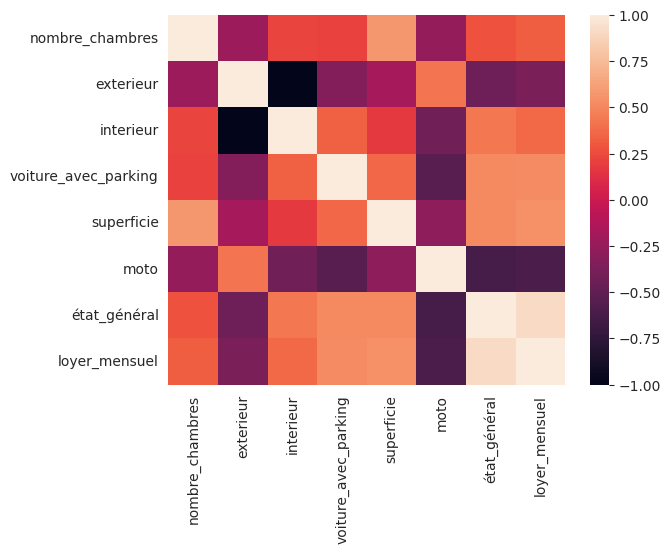

In [106]:
import seaborn as sns
strong_corr = correlation[(correlation > 0.3)]
corrmat = maison_without_quartier[strong_corr.index].corr()
sns.heatmap(corrmat)

In [107]:
# Normalisation
target = "loyer_mensuel"
features = corrmat.drop([target]).index
maison_normalisation = (maison_without_quartier[features].astype(float) - maison_without_quartier[features].min().astype(float)) / (maison_without_quartier[features].max().astype(float) - maison_without_quartier[features].min().astype(float))
#maison_normalisation = maison_without_quartier[features]

In [108]:
maison_normalisation.var().sort_values()

superficie              0.033209
interieur               0.092134
exterieur               0.092134
nombre_chambres         0.093043
état_général            0.144013
moto                    0.177966
voiture_avec_parking    0.252064
dtype: float64

In [109]:
variance_sorted = maison_normalisation.var().sort_values()

In [110]:
variance_sorted

superficie              0.033209
interieur               0.092134
exterieur               0.092134
nombre_chambres         0.093043
état_général            0.144013
moto                    0.177966
voiture_avec_parking    0.252064
dtype: float64

In [111]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def superficie_into_float(df):
    df['superficie'] = df['superficie'].apply(lambda x: x.replace(",", ".") if type(x) == str else x).astype(float)
    return df

def meuble_into_oui_non(df):
    df['meublé'] = df['meublé'].apply(lambda x: "oui" if x == "True" else ("non" if x == "False" else x))
    return df

def loyer_mensuel_fillna(df):
    df['loyer_mensuel'] = df['loyer_mensuel'].fillna(df['loyer_mensuel'].mean())
    return df

def etat_general_into_bon_mauvais_moyen(df):
    etat_general = [
        ("mauvais", 0, 300000),
        ("moyen", 300000, 800000),
        ("bon", 800000, math.inf)
    ]
    df['état_général'] = df['loyer_mensuel'].apply(lambda x: etat_general[0][0] if etat_general[0][1] <= x < etat_general[0][2] else (etat_general[1][0] if etat_general[1][1] <= x < etat_general[1][2] else etat_general[2][0]))
    return df

def douche_wc_separate(df):
    one_hot_douche_wc = pd.get_dummies(df['douche_wc'])
    df = one_hot_douche_wc.join(df)
    return df.drop('douche_wc',axis = 1)

def superficie_fillna(df):
    quantile_superficie = df['superficie'].quantile([0.25,0.5,0.75])
    df['superficie'] = df['superficie'].fillna(df.apply(lambda x: quantile_superficie[0.25] if x['état_général'] == "mauvais" else (quantile_superficie[0.5] if x['état_général'] == "moyen" else quantile_superficie[0.75]), axis = 1))
    return df

def aberrante_value_superficie(df):
    quantile_superficie = df['superficie'].quantile([0.25,0.5,0.75])
    Q1_superficie = quantile_superficie[0.25]
    Q3_superficie = quantile_superficie[0.75]
    IQR_super = Q3_superficie - Q1_superficie
    # Define the lower and upper thresholds
    lower_bound_superficie = Q1_superficie - 1.5 * IQR_super
    upper_bound_superficie = Q3_superficie + 1.5 * IQR_super
    return df[(df['superficie'] > lower_bound_superficie) & (df['superficie'] < upper_bound_superficie)]

def aberrante_value_loyer_mensuel(df):
    quantile_loyer = df['loyer_mensuel'].quantile([0.25,0.5,0.75])
    Q1_loyer_mensuel = quantile_loyer[0.25]
    Q3_loyer_mensuel = quantile_loyer[0.75]
    IQR_loyer_mensuel = Q3_loyer_mensuel - Q1_loyer_mensuel
    # Define the lower and upper thresholds
    lower_bound_loyer_mensuel = Q1_loyer_mensuel - 1.5 * IQR_loyer_mensuel
    upper_bound_loyer_mensuel = Q3_loyer_mensuel + 1.5 * IQR_loyer_mensuel
    return df[(df['loyer_mensuel'] > lower_bound_loyer_mensuel) & (df['loyer_mensuel'] < upper_bound_loyer_mensuel)]

def etat_general_into_numerical(df):
    mapping_etat_general = {
        "bon": 3,
        "moyen": 2,
        "mauvais": 1
    }
    pd.set_option('future.no_silent_downcasting', True)
    df['état_général'] = df['état_général'].replace(mapping_etat_general)
    return df

def type_d_acces_separate(df):
    one_hot_type_acces = pd.get_dummies(df['type_d_acces'])
    df = one_hot_type_acces.join(df)
    return df.drop('type_d_acces',axis = 1)

def meuble_into_numerical(df):
    df['meublé'] = df['meublé'].fillna("non")
    mapping_meuble = {
        "oui": 2,
        "non": 1
    }
    df['meublé'] = df['meublé'].replace(mapping_meuble)
    return df

def quartier_remove(df):
    return df.loc[:, df.columns != 'quartier']

def standardization(df):
    correlation_norm = df.corr()
    correlation_norm = correlation_norm[target].abs().sort_values()
    strong_corr_norm = correlation_norm[(correlation_norm > 0.35)]
    corr_math_norm = df[strong_corr_norm.index].corr()
    features_standardization = corr_math_norm.index
    return scaler.fit_transform(df[features_standardization])

def pre_treatment(df):
    df_pre_trait = superficie_into_float(df)
    df_pre_trait = meuble_into_oui_non(df_pre_trait)
    df_pre_trait = loyer_mensuel_fillna(df_pre_trait)
    df_pre_trait = etat_general_into_bon_mauvais_moyen(df_pre_trait)
    df_pre_trait = douche_wc_separate(df_pre_trait)
    df_pre_trait = superficie_fillna(df_pre_trait)
    df_pre_trait = aberrante_value_superficie(df_pre_trait)
    df_pre_trait = aberrante_value_loyer_mensuel(df_pre_trait)
    df_pre_trait = etat_general_into_numerical(df_pre_trait)
    df_pre_trait = type_d_acces_separate(df_pre_trait)
    df_pre_trait = meuble_into_numerical(df_pre_trait)
    y_targ = df_pre_trait[target]
    df_pre_trait = quartier_remove(df_pre_trait)
    df_pre_trait = standardization(df_pre_trait)
    return df_pre_trait, y_targ

In [112]:
columns = variance_sorted[(variance_sorted > 0.05)].index
maison_normalisation = maison_normalisation[columns]

In [113]:
columns

Index(['interieur', 'exterieur', 'nombre_chambres', 'état_général', 'moto',
       'voiture_avec_parking'],
      dtype='object')

In [114]:
maison_normalisation

,interieur,exterieur,nombre_chambres,état_général,moto,voiture_avec_parking
0,1.0,0.0,0.333333,0.5,1.0,0.0
1,1.0,0.0,0.333333,0.0,1.0,0.0
2,0.0,1.0,0.000000,0.0,1.0,0.0
3,0.0,1.0,0.333333,0.0,1.0,0.0
4,1.0,0.0,0.333333,0.5,0.0,1.0
...,...,...,...,...,...,...
122,1.0,0.0,0.333333,1.0,0.0,0.0
123,1.0,0.0,0.333333,1.0,0.0,1.0
124,1.0,0.0,0.333333,1.0,0.0,0.0
125,1.0,0.0,0.666667,1.0,0.0,0.0


<Axes: >

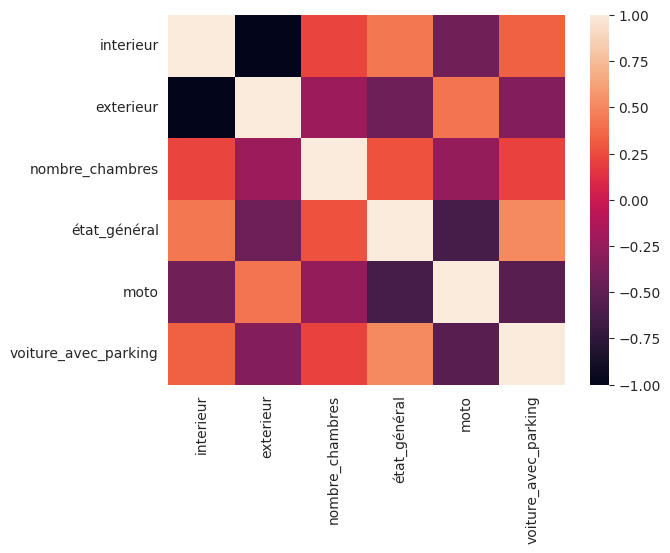

In [115]:
sns.heatmap(maison_normalisation.corr())

In [116]:
columns

Index(['interieur', 'exterieur', 'nombre_chambres', 'état_général', 'moto',
       'voiture_avec_parking'],
      dtype='object')

In [117]:
scaler = StandardScaler()
maison_features = maison_without_quartier.loc[:, maison_without_quartier.columns != target]
maison_standardization = scaler.fit_transform(maison_features)

In [118]:
maison_standardization

array([[ 1.83585685, -0.39605902, -0.41026434, ..., -0.10230456,
        -0.18731716, -0.41489312],
       [ 1.83585685, -0.39605902, -0.41026434, ..., -0.10230456,
        -0.18731716, -1.73806577],
       [ 1.83585685, -0.39605902, -0.41026434, ..., -1.19975346,
        -0.18731716, -1.73806577],
       ...,
       [-0.54470478, -0.39605902,  2.43745287, ..., -0.10230456,
        -0.18731716,  0.90827953],
       [-0.54470478,  2.52487623, -0.41026434, ...,  0.99514434,
         5.33853913,  0.90827953],
       [-0.54470478, -0.39605902, -0.41026434, ..., -1.19975346,
         5.33853913,  0.90827953]], shape=(118, 10))

In [119]:
# Valeur expliquée
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = maison[target]
X_standard = maison_standardization

In [120]:
y

0       300000
1       180000
2       170000
3       250000
4       450000
        ...   
122    1000000
123    1000000
124    1000000
125    1000000
126    1000000
Name: loyer_mensuel, Length: 118, dtype: int64

In [121]:
lr = LinearRegression()
predict_standard = lr.fit(X_standard, y)
y_pred = lr.predict(X_standard)

In [122]:
lr.predict(X_standard)

array([ 486332.24686992,   64998.47917375,  124522.75675676,
        144494.41587829,  575462.62083441,  595434.27995593,
       1077937.75805741,   28344.17175987,  144494.41587829,
        144494.41587829, 1052310.17851316,  595434.27995593,
        575462.62083441, 1055646.70817163,  555986.35520281,
         45026.82005223,  543577.49664049,  543799.93195105,
         64998.47917375,  124522.75675676, 1147951.67729761,
        575462.62083441,   27184.47637774,  595434.27995593,
        131411.09550679,  575462.62083441,   64998.47917375,
       1085675.47509787, 1015703.38992858, 1055646.70817163,
        486332.24686992, 1015703.38992858,  534902.51952846,
       1035675.0490501 ,  586351.47336499, 1015703.38992858,
        575462.62083441,  578799.15049288,  578799.15049288,
       1035675.0490501 ,  466912.21841741, 1032928.95054017,
        572716.52232448,  151382.75462831,  575462.62083441,
        595434.27995593,  947908.13903562, 1032338.51939163,
        954881.5416244 ,

In [123]:
predict_standard.score(X_standard, y)

0.8496680086925923

In [124]:
np.sqrt(mean_squared_error(y, y_pred))

np.float64(144837.2372777838)

## 📌 Partie 2 : Modélisation

In [125]:
class MyLinearRegression:
    def __init__(self):
        self.theta_n = None
        self.theta_0 = None

    def fit(self, x_var, y_real):
        x_var = x_var.astype(float)
        # Add bias term (column of 1s) to X
        X_b = np.c_[np.ones((x_var.shape[0], 1)), x_var]  # Add x0 = 1 to each instance
        # Normal Equation: theta = (X^T X)^(-1) X^T y
        theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_real)
        self.theta_0 = theta[0]
        self.theta_n = theta[1:]

    def predict(self, x_var):
        # Add bias term (column of 1s) to X
        X_b = np.c_[np.ones((x_var.shape[0], 1)), x_var] # Add x0 = 1 to each instance
        # np.r_ (Merge the first Vector [0] with the Vector [1])
        return X_b.dot(np.r_[self.theta_0, self.theta_n])

    def get_r2_score(self, x_var, y_real):
        """
        Formule: 1 - [sum((y[i] - y_predicted[i]) ^ 2) - sum((y[i] - y_mean) ^ 2)]
        """
        y_predicted = self.predict(x_var)
        ss_reg = np.sum((y_real - y_predicted) ** 2)
        ss_tot = np.sum((y_real - np.mean(y_real)) ** 2)
        return 1 - (ss_reg / ss_tot)

    def get_rmse(self, x_var, y_real):
        """
        Formule: np.sqrt((1 / n) * sum((y[i] - y_predicted[i]) ^ 2))
        """
        y_predicted = self.predict(x_var)
        return np.sqrt(np.sum((y_real - y_predicted) ** 2) / y_real.shape[0])

In [126]:
X = maison_normalisation.iloc[:, maison_normalisation.columns != target]

In [127]:
# Split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [128]:
lr_2 = MyLinearRegression()
lr_2.fit(X_train, y_train)

In [129]:
lr_2.predict(X_test)

array([960975.00217227, 958077.79815933, 922442.54642442, 925339.75043735,
       534168.16600703, 922442.54642442, 958077.79815933, 457079.30412849,
       960975.00217227, 922442.54642442, 993713.04989425, 960975.00217227])

In [130]:
lr_2.get_rmse(X_test, y_test)

np.float64(79420.38033573334)

In [131]:
lr_2.get_r2_score(X_test, y_test)

np.float64(0.862170873896078)

In [132]:
X_2, y_2 = pre_treatment(maison_2)

In [133]:
X_2

array([[-0.33646329,  0.33646329, -0.98319208, -0.14219553,  1.83585685,
        -0.41489312, -1.03857832],
       [-0.33646329,  0.33646329, -0.98319208, -0.7947956 ,  1.83585685,
        -1.73806577, -1.35981618],
       [ 2.97209242, -2.97209242, -0.98319208, -0.7947956 ,  1.83585685,
        -1.73806577, -1.386586  ],
       [ 2.97209242, -2.97209242, -0.98319208, -0.7947956 ,  1.83585685,
        -1.73806577, -1.17242743],
       [-0.33646329,  0.33646329,  1.01709526, -0.14219553, -0.54470478,
        -0.41489312, -0.637031  ],
       [-0.33646329,  0.33646329,  1.01709526, -0.14219553, -0.54470478,
        -0.41489312,  0.03221453],
       [-0.33646329,  0.33646329,  1.01709526,  2.5044603 , -0.54470478,
         0.90827953,  1.90610203],
       [-0.33646329,  0.33646329, -0.98319208, -1.33862899,  1.83585685,
        -1.73806577, -1.62751439],
       [ 2.97209242, -2.97209242, -0.98319208, -0.7947956 ,  1.83585685,
        -1.73806577, -1.44012564],
       [ 2.97209242, -2.9720

In [134]:
y_2

0       300000
1       180000
2       170000
3       250000
4       450000
        ...   
122    1000000
123    1000000
124    1000000
125    1000000
126    1000000
Name: loyer_mensuel, Length: 118, dtype: int64

In [135]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.3, random_state=1)

In [136]:
X_2_train

array([[-0.33646329,  0.33646329, -0.98319208, -1.37488455, -0.54470478,
        -0.41489312, -0.5031819 ],
       [-0.33646329,  0.33646329,  1.01709526, -1.59241791, -0.54470478,
         0.90827953,  0.83530917],
       [-0.33646329,  0.33646329,  1.01709526, -0.03342885, -0.54470478,
        -0.41489312, -0.77088011],
       [ 2.97209242, -2.97209242, -0.98319208, -0.7947956 ,  1.83585685,
        -1.73806577, -1.52043511],
       [-0.33646329,  0.33646329,  1.01709526, -0.7947956 , -0.54470478,
         0.90827953,  0.83530917],
       [-0.33646329,  0.33646329,  1.01709526,  2.10564915, -0.54470478,
         0.90827953,  2.17380024],
       [-0.33646329,  0.33646329,  1.01709526, -0.14219553, -0.54470478,
        -0.41489312, -0.5031819 ],
       [-0.33646329,  0.33646329,  1.01709526, -0.43224001, -0.54470478,
         0.90827953,  0.83530917],
       [-0.33646329,  0.33646329,  1.01709526,  1.12674905, -0.54470478,
         0.90827953,  1.3707056 ],
       [-0.33646329,  0.3364

In [137]:
lr_3 = MyLinearRegression()
lr_3.fit(X_2_train, y_2_train)

In [138]:
lr_3.predict(X_2_test)

array([ 995082.17812638,  995082.17812638,  895082.17812638,
        995082.17812638,  395082.17812638,  995082.17812638,
        895082.17812638,  395082.17812638,  895082.17812638,
        995082.17812638,  995082.17812638,  795082.17812638,
        242194.85660972,  445082.17812638,  895082.17812638,
        795082.17812638,  795082.17812638, 1025082.17812637,
        595082.17812637,  295082.17812638,  595082.17812637,
        645082.17812637,  295082.17812638,  845082.17812638,
        995082.17812638,  995082.17812638,  795082.17812638,
        495082.17812638,  972194.85660972,  895082.17812638,
       1495082.17812637,  545082.17812637,  695082.17812637,
        495082.17812638,  995082.17812638,  995082.17812638])

In [139]:
lr_3.get_rmse(X_2_test, y_2_test)

np.float64(17674.906639026485)

In [140]:
lr_3.get_r2_score(X_2_test, y_2_test)

np.float64(0.9958132193399881)